In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
# from xgboost import XGBClassifier
from scipy.stats import norm
from matplotlib.ticker import NullFormatter
from sklearn import linear_model, svm
from sklearn.learning_curve import validation_curve
from sklearn.model_selection  import StratifiedKFold, GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, classification_report
from sklearn.ensemble import RandomForestRegressor
import re
import random
import warnings
warnings.filterwarnings('ignore')
from bayes_opt import BayesianOptimization

/home/fschmidt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/fschmidt/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
#============================================================================

df1 = pd.DataFrame(pd.read_csv('train.csv'))
df2 = pd.DataFrame(pd.read_csv('test.csv'))

# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

df1['Sex'] = df1['Sex'].map({'female': 1, 'male': 0})
df1['Embarked'] = df1['Embarked'].map({'Q': 1, 'C': 0, 'S': 2})
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
df1["Age"] = imp.fit_transform(df1[["Age"]]).ravel()
df1['Embarked'] = imp.fit_transform(df1[['Embarked']]).ravel()
df1.Embarked = df1.Embarked.astype(int)
df1.Age = df1.Age.astype(int)
df1['FamilySize'] = df1['SibSp'] + df1['Parch'] + 1
df1 = df1.assign(FamilySize = pd.Series(df1['FamilySize']))
df1['HasCabin'] = df1['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
df1['Name_length'] = df1['Name'].apply(len)

#df1['IsAlone'] = 0
#df1.loc[df1['FamilySize'] == 1, 'IsAlone'] = 1

df1['Single'] = df1['FamilySize'].map(lambda s: 1 if s == 1 else 0)
df1['SmallF'] = df1['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df1['MedF'] = df1['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df1['LargeF'] = df1['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

df1['Title'] = df1['Name'].apply(get_title)
df1['Title'] = df1['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df1['Title'] = df1['Title'].replace('Mlle', 'Miss')
df1['Title'] = df1['Title'].replace('Ms', 'Miss')
df1['Title'] = df1['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df1['Title'] = df1['Title'].map(title_mapping)
df1['Title'] = df1['Title'].fillna(0)

#df1["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df1['Cabin'] ]) #zmapowac na inty
#df1['Cabin'] = df1['Cabin'].map({'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'T': 1})
df1 = df1.drop(columns = ['PassengerId', 'Cabin','Name', 'Ticket', 'Fare', 'Name_length', 'Age']) # dodano age
    
#============================================================================
    
df2['Sex'] = df2['Sex'].map({'female': 1, 'male': 0})
df2['Embarked'] = df2['Embarked'].map({'Q': 1, 'C': 0, 'S': 2})
imp = Imputer(missing_values = 'NaN', strategy = 'most_frequent', axis = 0)
df2["Age"] = imp.fit_transform(df2[["Age"]]).ravel()
df2['Embarked'] = imp.fit_transform(df2[['Embarked']]).ravel()
df2.Embarked = df2.Embarked.astype(int)
df2.Age = df2.Age.astype(int)
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1
df2 = df2.assign(FamilySize = pd.Series(df2['FamilySize']))    
df2['HasCabin'] = df2['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
df2['Name_length'] = df2['Name'].apply(len)

#df1['IsAlone'] = 0
#df1.loc[df1['FamilySize'] == 1, 'IsAlone'] = 1

df2['Single'] = df2['FamilySize'].map(lambda s: 1 if s == 1 else 0)
df2['SmallF'] = df2['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
df2['MedF'] = df2['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df2['LargeF'] = df2['FamilySize'].map(lambda s: 1 if s >= 5 else 0)

df2['Title'] = df2['Name'].apply(get_title)
df2['Title'] = df2['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df2['Title'] = df2['Title'].replace('Mlle', 'Miss')
df2['Title'] = df2['Title'].replace('Ms', 'Miss')
df2['Title'] = df2['Title'].replace('Mme', 'Mrs')
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
df2['Title'] = df2['Title'].map(title_mapping)
df2['Title'] = df2['Title'].fillna(0)

#df2["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df2['Cabin'] ]) #zmapowac na inty
#df2['Cabin'] = df2['Cabin'].map({'A': 1, 'B': 1, 'C': 1, 'D': 1, 'E': 1, 'F': 1, 'G': 1, 'T': 1})
df2 = df2.drop(columns = ['Name', 'Cabin', 'Ticket', 'Fare', 'Name_length', 'Age']) # dodano age

#print(df1)
#print(df2)

In [3]:
def perform_repeated_cv(X, y):
    #set random seed for repeartability
#     random.seed(1)

    #set the number of repetitions
    n_reps = 50

    for u in range(n_reps):

        #randomly shuffle the dataset
#         indices = np.arange(X.shape[0])
#         np.random.shuffle(indices)
#         X = X.iloc[indices] 
#         y = y.iloc[indices] 
        # dataset has been randomly shuffled
        
        #initialize vector to keep predictions from all folds of the cross-validation
        y_predict_lgb = np.zeros(y.shape)
        y_predict_xgb = np.zeros(y.shape)
        y_predict_reg = np.zeros(y.shape)

        #perform 10-fold cross validation
        skf = StratifiedKFold(n_splits = 5, random_state = 142)
#         skf.get_n_splits(X, y)

        for train, test in skf.split(X, y):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]

#             standardization
            sc = StandardScaler().fit(X_train)
            X_train = sc.transform(X_train)
            X_test = sc.transform(X_test)
            
        #============================================================================
            
            d_train = lgb.Dataset(X_train, label = y_train)

            params = {'boosting_type': 'gbdt',
                     'max_depth': -1,
                     'objective': 'binary',
                     'nthread': 3,
                     'num_leaves': 6,
                     'learning_rate': 0.1,
                     'max_bin': 512,
                     'subsample_for_bin': 200,
                     'subsample': 1,
                     'subsample_freq': 1,
                     'colsample_bytree': 0.6,
                     'reg_alpha': 0.5,
                     'reg_lambda': 4,
                     'min_split_gain': 0.5,
                     'min_child_weight': 1,
                     'min_child_samples': 5,
                     'scale_pos_weight': 1,
                     'num_class': 1,
                     'metric': 'auc'}
#             params['learning_rate'] = 0.0075
#             params['boosting_type'] = 'gbdt'
#             params['objective'] = 'binary'
#             params['metric'] = 'auc'
#             params['sub_feature'] = 0.5
#             params['num_leaves'] = 100
#             params['min_data'] = 50
#             params['max_depth'] = 15
#             params['max_bin'] = 150
#             params['num_iterations'] = 50
#             params['lambda_l2'] = 0.5
            
            modellgb = lgb.train(params, d_train, 100)
            y_predict_lgb[test] = modellgb.predict(X_test) 

            # {'boosting_type': 'gbdt',
            #  'max_depth': -1,
            #  'objective': 'binary',
            #  'nthread': 3,
            #  'num_leaves': 6,
            #  'learning_rate': 0.1,
            #  'max_bin': 512,
            #  'subsample_for_bin': 200,
            #  'subsample': 1,
            #  'subsample_freq': 1,
            #  'colsample_bytree': 0.6,
            #  'reg_alpha': 0.5,
            #  'reg_lambda': 4,
            #  'min_split_gain': 0.5,
            #  'min_child_weight': 1,
            #  'min_child_samples': 5,
            #  'scale_pos_weight': 1,
            #  'num_class': 1,
            #  'metric': 'auc'}
            
        #============================================================================            
            
            xgtrain = xgb.DMatrix(X_train, y_train.values)
            xgtest = xgb.DMatrix(X_test)

            param = {'max_depth': 10, 
                     'min_child_weigth': 3, 
                     'eta': 0.02, 
                     'silent': 1,
                     'eval_metric': 'auc',
                     'seed': 1001,
                     'colsample_bytree': 0.9,
                     'subsample': 0.9,
                     'gamma': 0.0964,
                     'objective':'binary:logistic', 
                     'lambda': 2,
                     'alpha': 0.03}
            num_round = 150
            modelxgb = xgb.train(param, xgtrain, num_round)
            y_predict_xgb[test] = modelxgb.predict(xgtest)
            
# xgb            Best hyperparameters:
# {'subsample': 0.8, 'min_child_weight': 15, 'max_depth': 5, 'gamma': 0.5, 'colsample_bytree': 0.8}


        #============================================================================

            lm = linear_model.LinearRegression()
            modelreg = lm.fit(X_train, y_train)
            y_predict_reg[test]  = modelreg.predict(X_test)
            
        #============================================================================
        
    for i in range(0, len(y_predict_lgb)):
        y_predict_lgb[i] = (y_predict_lgb[i] - y_predict_lgb.min()) / (y_predict_lgb.max() - y_predict_lgb.min())
    
    for i in range(0, len(y_predict_reg)):
        y_predict_reg[i] = (y_predict_reg[i] - y_predict_reg.min()) / (y_predict_reg.max() - y_predict_reg.min())
    
    for i in range(0, len(y_predict_xgb)):
        y_predict_xgb[i] = (y_predict_xgb[i] - y_predict_xgb.min()) / (y_predict_xgb.max() - y_predict_xgb.min()) 
        
    #============================================================================
    
    return y_predict_lgb, y_predict_xgb, y_predict_reg, modelreg, modelxgb, modellgb

In [4]:
#trenowanie

X = df1.drop(columns = ['Survived'])
y = df1['Survived']

y_predict_lgb, y_predict_xgb, y_predict_reg, modelreg, modelxgb, modellgb = perform_repeated_cv(X, y)

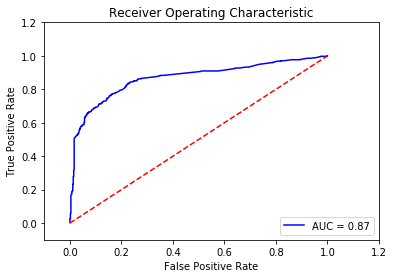

In [5]:
#============================================================================
# XGB

actual = y #df1['Survived']
predictions = y_predict_xgb #df2t

#print(actual)
#print(predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

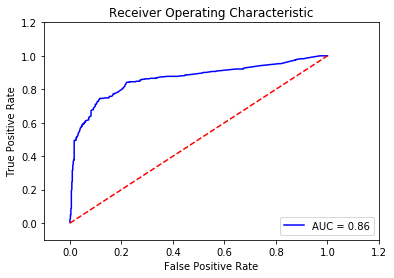

In [6]:
#============================================================================
# LGBM

actual = y #df1['Survived']
predictions = y_predict_lgb #df2t

#print(actual)
#print(predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

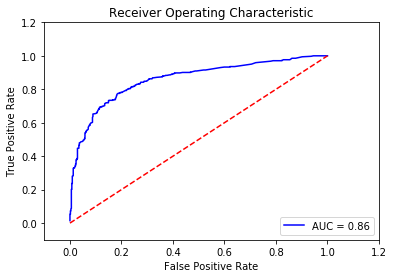

In [7]:
#============================================================================
# REG

actual = y #df1['Survived']
predictions = y_predict_reg #df2t

#print(actual)
#print(predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [8]:
# testowanie
Xt = df2.drop(columns = ['PassengerId'])
yt = df2['PassengerId']

sc = StandardScaler()
Xt_test = sc.fit_transform(Xt) # moze tu byc gdzies blad
xgt_test = xgb.DMatrix(Xt_test)

yt_predict_reg = modelreg.predict(Xt_test) # reg

yt_predict_xgb = modelxgb.predict(xgt_test) # xgb - musi dostac wartosci jako xgbmatrix

yt_predict_lgb = modellgb.predict(Xt_test) #lgbm 

for i in range(0, len(yt_predict_lgb)):
    yt_predict_lgb[i] = (yt_predict_lgb[i] - yt_predict_lgb.min()) / (yt_predict_lgb.max() - yt_predict_lgb.min())
    
for i in range(0, len(yt_predict_reg)):
    yt_predict_reg[i] = (yt_predict_reg[i] - yt_predict_reg.min()) / (yt_predict_reg.max() - yt_predict_reg.min())
    
for i in range(0, len(yt_predict_xgb)):
    yt_predict_xgb[i] = (yt_predict_xgb[i] - yt_predict_xgb.min()) / (yt_predict_xgb.max() - yt_predict_xgb.min())

In [9]:
# ok 1 przedstawic dane w DF jak powyzej
# ok 2 stworzyc modele i je wytrenowac
# ok 3 znormalizowac zeby moc je wykorzystac
# chyba ok 4 predykcje testowe zostaja wykorzystane jako nowe featury do train setu 
    # musi byc jakis for ktory by iterowal po splitach
# chyba ok 5 OOF: set zostaje dzielony na foldy - w tym miejscu chyba zostaja wprowadzane wartosci modeli jako nowe featury
    # jak powyzej
# ok 6 supermodel (random forest) na podstawie nowego train setu sie uczy
# ok 7 supermodel jest w stanie ocenic test set i podac wynik

# sprobowanie z regresja i bez niej
# dodanie M_features do test setu
# appendowanie wartosci - len(y_predict_lgbm) = 177 przez splitowanie - pdpbnie 1/5 jest oceniana

In [10]:
M_features = pd.DataFrame({'M_lgbm': y_predict_lgb, 'M_xgb': y_predict_xgb, 'M_reg': y_predict_reg})
# print(M_features)

Mt_features = pd.DataFrame({'Mt_lgbm': yt_predict_lgb, 'Mt_xgb': yt_predict_xgb, 'Mt_reg': yt_predict_reg})
# print(Mt_features)

# reg trzeba sie pozbyc bo psuje - do porownania
# do test setu tez trzeba dodac Mt_features

In [11]:
# df3 = pd.DataFrame() # training set dla rf
# df4 = pd.DataFrame() # test set dla rf 

# df3 = df3.assign(Survived = pd.Series(df1['Survived']), M_lgbm = pd.Series(M_features['M_lgbm']), M_xgb = pd.Series(M_features['M_xgb']))

# df4 = df4.assign(PassengerId = pd.Series(df2['PassengerId']), M_lgbm = pd.Series(Mt_features['Mt_lgbm']), Mt_xgb = pd.Series(Mt_features['Mt_xgb']))

df1 = df1.assign(M_lgbm = pd.Series(M_features['M_lgbm']), M_xgb = pd.Series(M_features['M_xgb']), M_reg = pd.Series(M_features['M_reg']))
df2 = df2.assign(Mt_lgbm = pd.Series(Mt_features['Mt_lgbm']), Mt_xgb = pd.Series(Mt_features['Mt_xgb']), Mt_reg = pd.Series(Mt_features['Mt_reg']))

In [12]:
def perform_repeated_cv_with_M_features(X, y):
    #set random seed for repeartability
#     random.seed(1)

    #set the number of repetitions
    n_reps = 50

    for u in range(n_reps):

        #randomly shuffle the dataset
#         indices = np.arange(X.shape[0])
#         np.random.shuffle(indices)
#         X = X.iloc[indices] 
#         y = y.iloc[indices] 
        # dataset has been randomly shuffled

        #initialize vector to keep predictions from all folds of the cross-validation
        y_predict_rf = np.zeros(y.shape)

        #perform 10-fold cross validation
        skf = StratifiedKFold(n_splits = 5, random_state = 142)
        skf.get_n_splits(X, y)

        for train, test in skf.split(X, y):
            X_train, X_test = X.iloc[train], X.iloc[test]
            y_train, y_test = y.iloc[train], y.iloc[test]

            #standardization
            sc = StandardScaler().fit(X_train)
            X_train = sc.transform(X_train)
            X_test = sc.transform(X_test)
            
        #============================================================================
        
            rf = RandomForestRegressor(n_estimators = 147, 
                           max_features = 0.1171,
                           max_depth = 9, 
                           min_samples_split = 12,
                           min_samples_leaf = 8,
                           bootstrap = True,
                           max_leaf_nodes = 25,
                           min_weight_fraction_leaf = 0.2,
                           random_state = 250) 
            
#            {'n_estimators': 400,
#  'min_samples_split': 10,
#  'min_samples_leaf': 4,
#  'max_features': 'sqrt',
#  'max_depth': 90,
#  'bootstrap': True}

            modelrf = rf.fit(X_train, y_train)
            y_predict_rf[test] = modelrf.predict(X_test)
            
        #============================================================================
        
#     for i in range(0, len(y_predict_rf)):
#         y_predict_rf[i] = (y_predict_rf[i] - y_predict_rf.min()) / (y_predict_rf.max() - y_predict_rf.min())
        
    return y_predict_rf, modelrf

In [13]:
#     n_estimators = number of trees in the foreset
#     max_features = max number of features considered for splitting a node
#     max_depth = max number of levels in each decision tree
#     min_samples_split = min number of data points placed in a node before the node is split
#     min_samples_leaf = min number of data points allowed in a leaf node
#     bootstrap = method for sampling data points (with or without replacement)

# print(df1,df2)

# Xrf = df3.drop(columns = ['Survived'])
# yrf = df3['Survived']

Xrf = df1.drop(columns = ['Survived'])
yrf = df1['Survived']

y_predict_rf, modelrf = perform_repeated_cv_with_M_features(Xrf, yrf)

#============================================================================    

# plt.scatter(y_predict_rf, y_predict_rf)

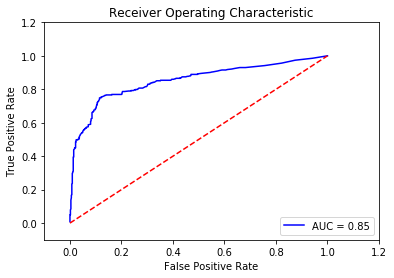

In [14]:
actual = yrf #df1['Survived']
predictions = y_predict_rf #df2t

#print(actual)
#print(predictions)

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f'% roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
dfkupa = pd.DataFrame(y_predict_rf)

dfkupa[0].value_counts()

0.249857    44
0.242197    41
0.245115    41
0.240694    37
0.243123    35
0.269195    14
0.256480    14
0.267546    11
0.349664     9
0.325005     9
0.258709     9
0.260671     8
0.308688     8
0.268256     8
0.514265     8
0.262860     7
0.387338     7
0.265187     7
0.257285     6
0.262822     6
0.531574     6
0.600657     6
0.253536     6
0.279627     6
0.261337     6
0.574774     5
0.263902     5
0.558920     5
0.536827     5
0.433451     5
            ..
0.558805     1
0.351594     1
0.580992     1
0.425196     1
0.344160     1
0.539494     1
0.377650     1
0.490423     1
0.575673     1
0.478162     1
0.605236     1
0.370977     1
0.516768     1
0.281700     1
0.291013     1
0.565059     1
0.560869     1
0.317690     1
0.331545     1
0.327720     1
0.343068     1
0.572494     1
0.322925     1
0.276552     1
0.316143     1
0.317111     1
0.596651     1
0.595728     1
0.333410     1
0.580563     1
Name: 0, Length: 349, dtype: int64

In [16]:
dfkupa = pd.DataFrame(y_predict_rf)

for i in range(len(dfkupa[0])):
    
    if(dfkupa[0][i] >= 0.435):
        dfkupa[0][i] = 1
    if(dfkupa[0][i] <= 0.435):
        dfkupa[0][i] = 0
print(accuracy_score(yrf, dfkupa[0]))

0.8282828282828283


In [17]:
# Xtrf = df4.drop(columns = ['PassengerId']) 
# ytrf = df4['PassengerId']

Xtrf = df2.drop(columns = ['PassengerId']) 
ytrf = df2['PassengerId']

ytrf = ytrf.reset_index(drop=True)
ytrf = pd.DataFrame(np.array(ytrf).reshape(len(ytrf)), columns = ['PassengerId'])

Xtrf = pd.DataFrame(Xtrf)
yt_predict_rf = modelrf.predict(Xtrf)

# for i in range(0, len(yt_predict_rf)):
#     yt_predict_rf[i] = (yt_predict_rf[i] - yt_predict_rf.min()) / (yt_predict_rf.max() - yt_predict_rf.min())

In [18]:
# wyznaczyc przedzialy dla rf - moga ulec zmianie jesli bede zmienial parametry zwiazane z rf
df_pred_rf = pd.DataFrame({'SurvivalPred': yt_predict_rf})

# print(df_pred_rf)

df_pred_rf['SurvivalPred'].value_counts()

0.336799    138
0.553739     25
0.345516     20
0.405423     19
0.506807     19
0.461694     18
0.545976     16
0.554151     14
0.341223     14
0.546387     11
0.337330     10
0.515857      7
0.446776      6
0.532693      5
0.428662      5
0.357975      4
0.502575      4
0.345523      4
0.468909      4
0.392738      3
0.528439      3
0.410130      3
0.353279      3
0.383220      2
0.418436      2
0.358375      2
0.519540      2
0.537337      2
0.511365      2
0.349658      2
           ... 
0.419292      2
0.405741      1
0.441058      1
0.464600      1
0.500687      1
0.409835      1
0.435998      1
0.467806      1
0.492864      1
0.353551      1
0.545100      1
0.507219      1
0.451057      1
0.349825      1
0.387983      1
0.420060      1
0.366577      1
0.453455      1
0.549246      1
0.423536      1
0.466468      1
0.542133      1
0.423954      1
0.532671      1
0.396585      1
0.515224      1
0.483632      1
0.484101      1
0.505321      1
0.493563      1
Name: SurvivalPred, Leng

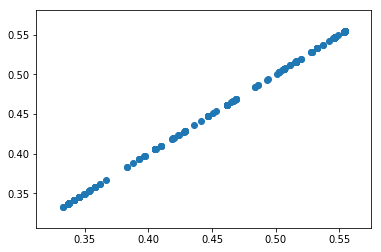

In [19]:
plt.scatter(df_pred_rf, df_pred_rf)

In [20]:
ytrf = ytrf.assign(Survived = pd.Series())
# print(yt)

for i in range(0, 418): # 0.55 daje 0.78947 na kaggle
    
    if(df_pred_rf['SurvivalPred'][i] > 0.46):
        ytrf['Survived'][i] = 1
    if(df_pred_rf['SurvivalPred'][i] <= 0.46):
        ytrf['Survived'][i] = 0

# print(yt)

In [21]:
umarloavgrf = (1 - sum(ytrf['Survived']) / 418) * 100

print('[AVG-rf] Umarło: ', umarloavgrf, '% pasażerów.')

[AVG-rf] Umarło:  62.91866028708134 % pasażerów.


In [22]:
ytrf['Survived'] = ytrf['Survived'].astype(int)
ytrf.to_csv('wynik-avg-stack-rf-079425.csv', index = False)